# Riabilitazione da Ictus con BCI
***
Questo progetto nasce durante l'hackathon BR4IN.IO 2021 organizzato da g-tec. 

Abbiamo analizzato un dataset di segnali ottenuti con una Brain Computer Interfaces (BCI) da **pazienti con ictus cronico**. Negli ultimi anni, le BCI sono state ampiamente utilizzate come **strumenti di riabilitazione** per recuperare la funzionalitá degli arti.

Nello specifico siamo nell'ambito della Motor Imagery (Immaginazione del movimento) grazie ai BCI, possiamo rilevare i segnali cerebrali e usarli per riconoscere la volontà del soggetto di muovere una parte del proprio corpo. Infatti, prima di eseguire un movimento, lo possiamo richiamare nella nostra mente e attiviamo una specifica area cerebrale. 

Questo segnale può essere registrato e interpretato per migliorare una terapia di riabilitazione.

Viene usato un **elettrostimolatore** per far compiere il movimento ai muscoli dell'avambraccio e muovere l'arto. 


#### **Ma qual è il nostro obiettivo?**
Nel nostro caso dovevamo classificare il segnale  mano sinistra o mano destra.

Abbiamo cercato di implementare il miglior classificatore in diverse situazioni:


* miglior classificatore specifico per paziente
* miglior classificatore per modello generalizzato 

In [ ]:
!pip install mne
import matplotlib.pyplot as plt
import mne 
from mne.decoding import CSP
from mne.decoding import Scaler
import numpy as np
import os
import pandas as pd
from scipy import io
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
import time
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
%matplotlib inline

# Descrizione dei dati
Abbiamo i dati di tre pazienti che hanno fatto il percorso di riabilitazione.
Per ogni paziente, abbiamo quattro set di dati:

**Prima della riabilitazione:**
* Set di Training
* Set di Test

**Dopo la riabilitazione:**
* Set di Training
* Set di Test

Ogni set è composto da:
* una matrice y che contiene il segnale registrato per ciascuno dei 16 canali con frequenza di campionamento di 256 Hz
* un vettore di trigger che contiene l'etichetta: +1 mano destra, -1 mano sinistra, 0 nessun movimento

# Pre-Processing dei segnali EEG
### Filtraggio di frequenza
Siamo interessati ai **ritmi mu e beta** nella banda di frequenza 8-30 hz, quindi abbiamo applicato un **filtro passa-banda**.

### Rimozione di artefatti
Abbiamo l'Analisi delle Componenti Indipendenti (ICA), un metodo di decomposizione lineare che permette la rimozione di artefatti come i movimenti oculari o l'attivazione dei muscoli facciali dai segnali.
ICA proietta i pattern delle fonti indesiderate sullo scalpo ed è possibile localizzarli ed eliminarli.
Abbiamo svolto questo processo affidandoci a EEGlab, un Matlab Toolbox di SCCN.
### Divisione dei segnali in epoch
Abbiamo suddiviso l'intero segnale in epoche da 8 e
da 2 secondi e assegnato ad ogni epoch la label corrispondente: 
*  +1 mano Sx 
*  -1 mano Dx



Organizziamo i dati in un dizionario annidato con la seguente struttura:

```
  data = {"patient1":{
                      "pre" : {"train": {"DxRaw" : [],
                                       "DxFilt" : [],
                                       "SxRaw" : [],
                                       "SxFilt" : [],
                                       "tr" : []},

                              "test" : {"DxRaw" : [],
                                       "DxFilt" : [],
                                       "SxRaw" : [],
                                       "SxFilt" : [],
                                       "tr" : []}},

                      "post": {"train": {"DxRaw" : [],
                                        "DxFilt" : [],
                                        "SxRaw" : [],
                                        "SxFilt" : [],
                                        "tr" : []},

                               "test" : {"DxRaw" : [],
                                        "DxFilt" : [],
                                        "SxRaw" : [],
                                        "SxFilt" : [],
                                        "tr" : []}}},

          "patient2":{"pre":{...},
                     "post": {...}},

          "patient3":{...}
        }
```


In [ ]:
from google.colab import  drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Risultati.zip -d /content/Risultati # Replace with your file path

Archive:  /content/drive/MyDrive/Risultati.zip
   creating: /content/Risultati/Risultati/
  inflating: /content/Risultati/Risultati/Processed_P1_post_test.mat  
  inflating: /content/Risultati/Risultati/Processed_P1_post_training.mat  
  inflating: /content/Risultati/Risultati/Processed_P1_pre_test.mat  
  inflating: /content/Risultati/Risultati/Processed_P1_pre_training.mat  
  inflating: /content/Risultati/Risultati/Processed_P2_post_test.mat  
  inflating: /content/Risultati/Risultati/Processed_P2_post_training.mat  
  inflating: /content/Risultati/Risultati/Processed_P2_pre_test.mat  
  inflating: /content/Risultati/Risultati/Processed_P2_pre_training.mat  
  inflating: /content/Risultati/Risultati/Processed_P3_post_test.mat  
  inflating: /content/Risultati/Risultati/Processed_P3_post_training.mat  
  inflating: /content/Risultati/Risultati/Processed_P3_pre_test.mat  
  inflating: /content/Risultati/Risultati/Processed_P3_pre_training.mat  


In [ ]:
path = "/content/Risultati/Risultati" # Replace with your own folder path


data = {"patient1":{"pre":{},
                    "post": {}},
        "patient2":{"pre":{},
                    "post": {}},
        "patient3":{"pre":{},
                    "post": {}}
        }

 
# Patient 1
processed_P1_pre_training = io.loadmat(path + '/Processed_P1_pre_training.mat')
processed_P1_pre_test = io.loadmat(path + '/Processed_P1_pre_test')
processed_P1_post_training= io.loadmat(path + '/Processed_P1_post_training.mat')
processed_P1_post_test= io.loadmat(path + '/Processed_P1_post_test.mat')

# Patient 2
processed_P2_pre_training = io.loadmat(path + '/Processed_P2_pre_training.mat')
processed_P2_pre_test = io.loadmat(path + '/Processed_P2_pre_test')
processed_P2_post_training= io.loadmat(path + '/Processed_P2_post_training.mat')
processed_P2_post_test= io.loadmat(path + '/Processed_P2_post_test.mat')

# Patient 3
processed_P3_pre_training = io.loadmat(path + '/Processed_P3_pre_training.mat')
processed_P3_pre_test = io.loadmat(path + '/Processed_P3_pre_test')
processed_P3_post_training= io.loadmat(path + '/Processed_P3_post_training.mat')
processed_P3_post_test= io.loadmat(path + '/Processed_P3_post_test.mat')

keys = list(processed_P1_pre_training.keys())
for key in keys[:3]:
  processed_P1_pre_training.pop(key)
  processed_P1_pre_test.pop(key)
  processed_P1_post_training.pop(key)
  processed_P1_post_test.pop(key)

  processed_P2_pre_training.pop(key)
  processed_P2_pre_test.pop(key)
  processed_P2_post_training.pop(key)
  processed_P2_post_test.pop(key)

  processed_P3_pre_training.pop(key)
  processed_P3_pre_test.pop(key)
  processed_P3_post_training.pop(key)
  processed_P3_post_test.pop(key)

data["patient1"]["pre"]["train"]= processed_P1_pre_training
data["patient1"]["pre"]["test"]= processed_P1_pre_test
data["patient1"]["post"]["train"] = processed_P1_post_training
data["patient1"]["post"]["test"] = processed_P1_post_test

data["patient2"]["pre"]["train"]= processed_P2_pre_training
data["patient2"]["pre"]["test"]= processed_P2_pre_test
data["patient2"]["post"]["train"] = processed_P2_post_training
data["patient2"]["post"]["test"] = processed_P2_post_test

data["patient3"]["pre"]["train"]= processed_P3_pre_training
data["patient3"]["pre"]["test"]= processed_P3_pre_test
data["patient3"]["post"]["train"] = processed_P3_post_training
data["patient3"]["post"]["test"] = processed_P3_post_test

Per ogni sessione abbiamo:

* frequenza di campionamento (256 hz)
* 40 samples di mano destra (40 campioni x 16 canali x 2048 campioni)
* 40 samples a sinistra (40 campioni x 16 canali x 2048 campioni)
* 80 labels y 
Il Dataset é **bilanciato**, non dobbiamo tenerne conto nello score che utilizzeremo, infatti useremo la semplice **Accuracy**.

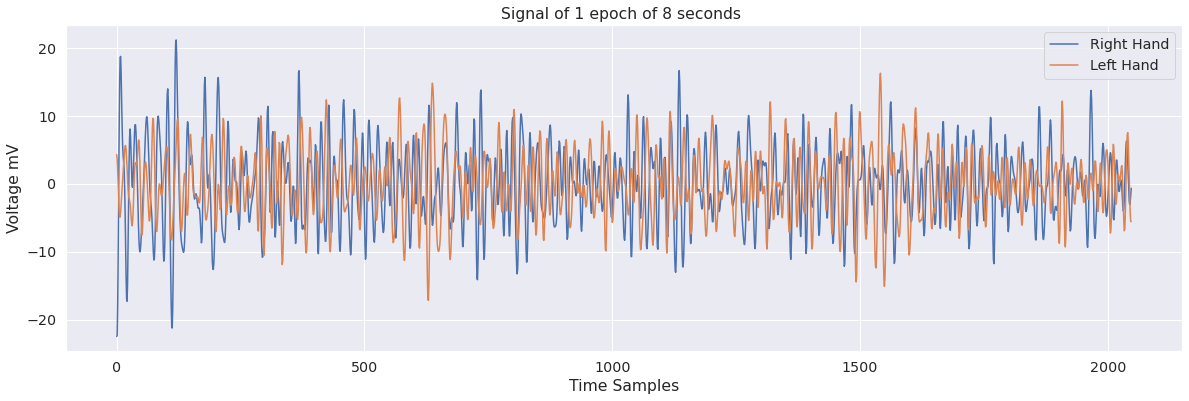

In [ ]:
#plotting                                           
#[epoch][channel]
plotx=data['patient1']['post']['train']['DxFilt'][9][4].transpose()
ploty=data['patient1']['post']['train']['SxFilt'][23][4].transpose()

plt.figure(figsize=(20,6))
plt.ylabel('Voltage mV')
plt.xlabel('Time Samples')
plt.title('Signal of 1 epoch of 8 seconds ')
plt.plot(plotx,label='Right Hand')
plt.plot(ploty,label='Left Hand')
plt.legend(loc="upper right")


# Feature Extraction

Dobbiamo estrarre le **features necessarie** per il processo di classificazione.
L'estrazione è stata condotta utilizzando **Common Spatial Filters **(CSP).
Dalla letteratura sembrerebbe che sia il metodo più efficace per ottenere features rappresentative dal segnale EEG.

L'Algoritmo CSP calcola le features la cui **varianza é massima** per discriminare le due classi di misure EEG.
Inoltre si comporta anche come **filtro spaziale** per cui é possibile proiettare le componenti sullo scalpo in ordine dalla varianza maggiore.

Il parametro più importante di CSP è il numero di componenti relativi alla riduzione dimensionale applicata da CSP e viene valutato tramite CrossValidation!

![](https://mne.tools/stable/_images/sphx_glr_decoding_csp_eeg_001.png)

In questo caso siamo interessati a CSP0 e CSP2 dove possiamo vedere proprio le 2 regioni di interesse attivate!

In [ ]:
patient='patient1'
step='pre'
X_train=np.concatenate([data[patient][step]['train']['DxFilt'],
                        data[patient][step]['train']['SxFilt']])
y_train=np.concatenate([-1*np.ones(len(data[patient][step]['train']['DxFilt'])),
                          np.ones(len(data[patient][step]['train']['SxFilt']))])

In [ ]:
csp=CSP(n_components=16,transform_into='average_power',cov_est='concat',component_order='alternate')
x=csp.fit_transform(X_train,y_train)

Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 16 dim * 4.3e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 16 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.


([], <a list of 0 Text major ticklabel objects>)

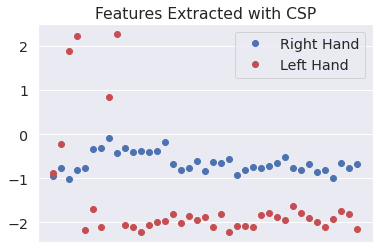

In [ ]:
plt.title('Features Extracted with CSP')
plt.plot(x[0:39,0],'bo',label='Right Hand')
plt.plot(x[40:79,1],'ro',label='Left Hand')
plt.legend()
plt.xticks([])

Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 16 dim * 7.5e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 26 (2.2e-16 eps * 16 dim * 7.2e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.


([], <a list of 0 Text major ticklabel objects>)

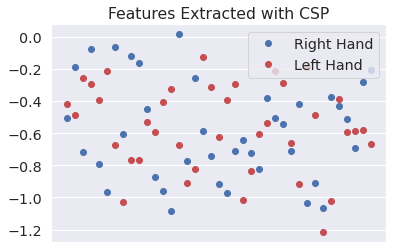

In [ ]:
patient='patient2'
step='post'
X_train=np.concatenate([data[patient][step]['train']['DxFilt'],
                        data[patient][step]['train']['SxFilt']])
y_train=np.concatenate([-1*np.ones(len(data[patient][step]['train']['DxFilt'])),
                          np.ones(len(data[patient][step]['train']['SxFilt']))])

csp=CSP(n_components=16,transform_into='average_power',cov_est='concat',component_order='alternate')
x=csp.fit_transform(X_train,y_train)
plt.title('Features Extracted with CSP')
plt.plot(x[0:39,0],'bo',label='Right Hand')
plt.plot(x[40:79,1],'ro',label='Left Hand')
plt.legend()
plt.xticks([])

# Pipeline For Every Classifier

##SCALER + COMMON SPATIAL PATTERN + CLASSIFIER

## Grid search

In [ ]:
from sklearn.metrics import make_scorer

def customized_GridSearch(clf, csp, parameters_clf, parameters_csp, X_train, y_train):

    # Grid Search pipeline
    pipeline = Pipeline([('scaler',scaler),('csp', csp), ('clf', clf)])

    # Grid Search parameters
    parameters = dict()
    parameters.update(parameters_csp)
    parameters.update(parameters_clf)
    
    # 5-fold Cross Validation Grid Search
    grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=True)

    print("=======Performing grid search...========")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)

    t0 = time.time()

    grid_search.fit(X_train, y_train)

    print("done in %0.3fs" % (time.time() - t0))
    print()
    
    # Best Model Result on CV
    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return grid_search

## Best Model

In [ ]:
def best_model_on_TestSet(grid_search, X_test, y_test):
    """
    Return the best model parameters and score on test set.
    """
    # Best Model Result on Test set
    score = grid_search.best_estimator_.score(X_test, y_test)
    print("Test score with best_estimator_: %0.3f" % score)
    best_parameters = grid_search.best_estimator_.get_params()
    print("\n")    
    plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test,normalize='all')
    return best_parameters, score

# 8s Epoch Patient Specific


In [ ]:
#SCALER
scaler = Scaler(scalings='mean')
# CSP
csp = CSP(log=True,transform_into='average_power')

## Linear Discriminant Analysis

In [ ]:
clf = LinearDiscriminantAnalysis(shrinkage='auto')
# Parameters 
parameters_csp = {    'csp__n_components' : (4,6,8)}
parameters_clf = {
    'clf__solver' :('eigen','svd','lsqr')
}

## Logistic Regression

In [ ]:
clf = LogisticRegression(penalty='l2',n_jobs=-1)
# Parameters 
parameters_csp = {    'csp__n_components' : ((4,6,8))}
parameters_clf = {    'clf__C' :np.logspace(0, 1, 5)   
}

## MultiLayer Percepeptron

In [ ]:
clf = MLPClassifier(learning_rate='adaptive',max_iter=1000,activation='relu')
# Parameters 
parameters_csp = {    'csp__n_components' : ((6,8))}

parameters_clf = {    'clf__hidden_layer_sizes':(100,500,1000),
                      'clf__alpha':np.logspace(-2, 0, 5)
}

Gridsearch for patient1 pre
=======Performing grid search...========
pipeline: ['scaler', 'csp', 'clf']
parameters:
{'csp__n_components': (6, 8), 'clf__hidden_layer_sizes': (100, 500, 1000), 'clf__alpha': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ])}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.5s


Computing rank from data with rank=None


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.2min finished


    Using tolerance 3.1 (2.2e-16 eps * 16 dim * 8.8e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.4 (2.2e-16 eps * 16 dim * 9.7e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
done in 74.598s

Best CV score: 0.812
Best parameters set:
	clf__alpha: 3.1622776601683795
	clf__hidden_layer_sizes: 500
	csp__n_components: 6
Test score with best_estimator_: 0.700


Gridsearch for patient1 post
=======Performing grid search...========
pipeline: ['scaler', 'csp', 'clf']
parameters:
{'csp__n_components': (6, 8), 'clf__hidden_layer_sizes': (100, 500, 1000), 'clf__alpha': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.3min finished


Computing rank from data with rank=None
    Using tolerance 3.4 (2.2e-16 eps * 16 dim * 9.6e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5 (2.2e-16 eps * 16 dim * 1e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
done in 78.448s

Best CV score: 0.887
Best parameters set:
	clf__alpha: 0.1
	clf__hidden_layer_sizes: 500
	csp__n_components: 8
Test score with best_estimator_: 0.684


Gridsearch for patient2 pre
=======Performing grid search...========
pipeline: ['scaler', 'csp', 'clf']
parameters:
{'csp__n_components': (6, 8), 'clf__hidden_layer_sizes': (100, 500, 1000), 'clf__alpha': array([ 0.1       ,  0.31622777,  1.        ,  3.1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.3min finished


Computing rank from data with rank=None
    Using tolerance 3.6 (2.2e-16 eps * 16 dim * 1e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5 (2.2e-16 eps * 16 dim * 9.8e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


done in 82.612s

Best CV score: 0.650
Best parameters set:
	clf__alpha: 0.1
	clf__hidden_layer_sizes: 500
	csp__n_components: 6
Test score with best_estimator_: 0.562


Gridsearch for patient2 post
=======Performing grid search...========
pipeline: ['scaler', 'csp', 'clf']
parameters:
{'csp__n_components': (6, 8), 'clf__hidden_layer_sizes': (100, 500, 1000), 'clf__alpha': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ])}
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.9s


Computing rank from data with rank=None


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.3min finished


    Using tolerance 3.6 (2.2e-16 eps * 16 dim * 1e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5 (2.2e-16 eps * 16 dim * 9.9e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
done in 77.196s

Best CV score: 0.713
Best parameters set:
	clf__alpha: 3.1622776601683795
	clf__hidden_layer_sizes: 100
	csp__n_components: 6
Test score with best_estimator_: 0.762


Gridsearch for patient3 pre
=======Performing grid search...========
pipeline: ['scaler', 'csp', 'clf']
parameters:
{'csp__n_components': (6, 8), 'clf__hidden_layer_sizes': (100, 500, 1000), 'clf__alpha': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ])}
F

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.2min finished


Computing rank from data with rank=None
    Using tolerance 3.6 (2.2e-16 eps * 16 dim * 1e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5 (2.2e-16 eps * 16 dim * 9.8e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
done in 71.144s

Best CV score: 0.834
Best parameters set:
	clf__alpha: 1.0
	clf__hidden_layer_sizes: 1000
	csp__n_components: 6
Test score with best_estimator_: 0.620


Gridsearch for patient3 post
=======Performing grid search...========
pipeline: ['scaler', 'csp', 'clf']
parameters:
{'csp__n_components': (6, 8), 'clf__hidden_layer_sizes': (100, 500, 1000), 'clf__alpha': array([ 0.1       ,  0.31622777,  1.        ,  3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.4s


Computing rank from data with rank=None


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


    Using tolerance 3.5 (2.2e-16 eps * 16 dim * 9.8e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7 (2.2e-16 eps * 16 dim * 1e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
done in 68.061s

Best CV score: 0.863
Best parameters set:
	clf__alpha: 3.1622776601683795
	clf__hidden_layer_sizes: 100
	csp__n_components: 6
Test score with best_estimator_: 0.912




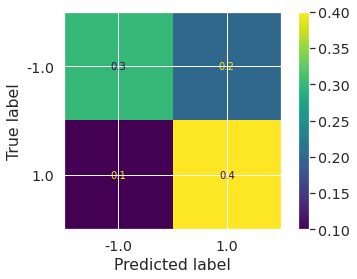

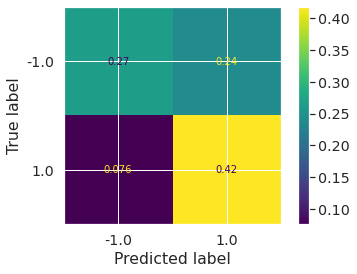

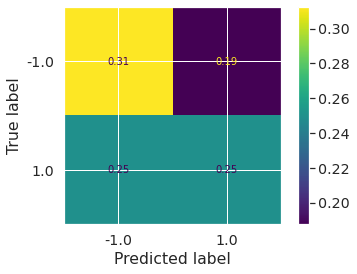

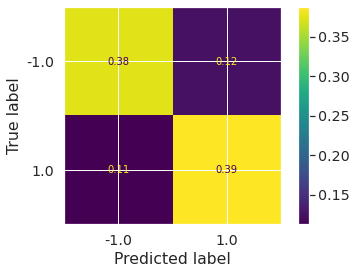

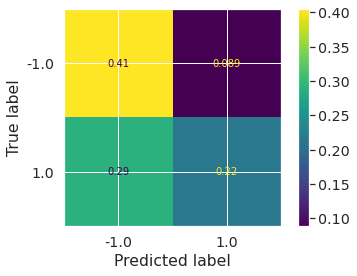

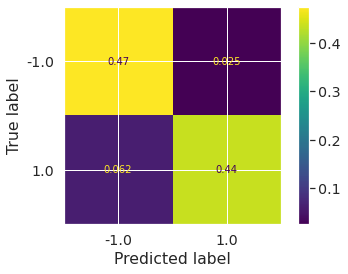

In [ ]:
#GRID SEARCH AND EVALUATION ON TEST SET
test_scores = {"patient1":{"pre":{},"post": {}}
               ,"patient2":{"pre":{},"post": {}}
               ,"patient3":{"pre":{},"post": {}}
              }
cv_scores = {"patient1":{"pre":{},"post": {}},
             "patient2":{"pre":{},"post": {}},
             "patient3":{"pre":{},"post": {}}
            }

best_params = {"patient1":{"pre":{},"post": {}},
               "patient2":{"pre":{},"post": {}},
               "patient3":{"pre":{},"post": {}}
               }

patients = ['patient1', 'patient2', 'patient3']
steps=['pre','post']

for patient in patients:
  for step in steps:
      X_train=np.concatenate([data[patient][step]['train']['DxFilt'],
                                data[patient][step]['train']['SxFilt']])
      y_train=np.concatenate([-1*np.ones(len(data[patient][step]['train']['DxFilt'])),
                                np.ones(len(data[patient][step]['train']['SxFilt']))])
      print("Gridsearch for",patient,step)
      grid_search= customized_GridSearch(clf, csp, parameters_clf, parameters_csp, X_train, y_train)
      cv_scores[patient][step]=grid_search.best_score_

      X_test=np.concatenate([data[patient][step]['test']['DxFilt'],data[patient][step]['test']['SxFilt']])
      y_test=np.concatenate([-1*np.ones(len(data[patient][step]['test']['DxFilt'])),
                            np.ones(len(data[patient][step]['test']['SxFilt']))])
      best_params[patient][step], test_scores[patient][step] = best_model_on_TestSet(grid_search, X_test, y_test)



patient1 pre   CrossVal Score: 0.812   Test Score: 0.700
patient1 post   CrossVal Score: 0.887   Test Score: 0.684
patient2 pre   CrossVal Score: 0.650   Test Score: 0.562
patient2 post   CrossVal Score: 0.713   Test Score: 0.762
patient3 pre   CrossVal Score: 0.834   Test Score: 0.620
patient3 post   CrossVal Score: 0.863   Test Score: 0.912

media sui cv score:  0.793  media sui test score: 0.707


Text(0.5, 1.0, 'Test Set Score')

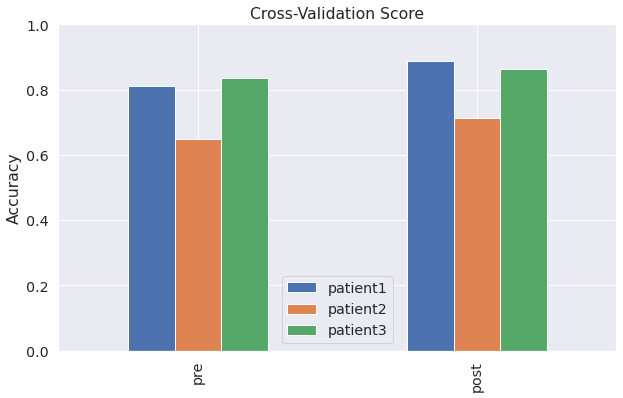

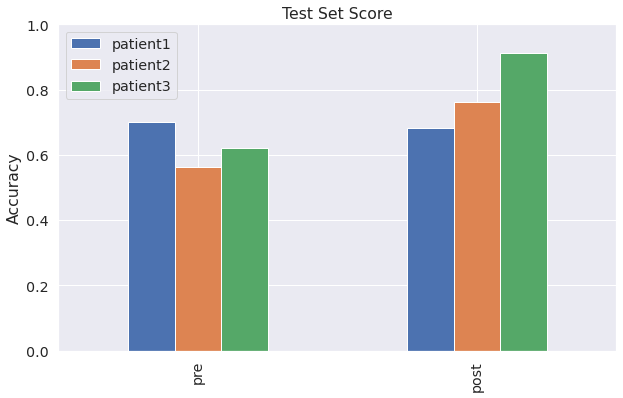

In [ ]:
df1=pd.DataFrame(cv_scores)
df2=pd.DataFrame(test_scores)

for patient in patients:
  for step in steps:
    print(patient,step,'  CrossVal Score: %0.3f' %cv_scores[patient][step],'  Test Score: %0.3f'%test_scores[patient][step])
print()
print('media sui cv score:  %0.3f'%df1.mean().mean(),' media sui test score: %0.3f'%df2.mean().mean())
df1.plot(kind='bar', figsize = (10,6),ylim=(0,1))
plt.ylabel("Accuracy")
plt.title("Cross-Validation Score")

df2.plot(kind='bar', figsize = (10,6),ylim=(0,1))
plt.ylabel("Accuracy")
plt.title("Test Set Score")

## Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

clf = VotingClassifier(estimators=[('logreg',LogisticRegression(penalty='l2',n_jobs=-1)),
                                   
                                    ('mlp', MLPClassifier(learning_rate='adaptive',max_iter=100)),
                                   
                                    ('lda',LinearDiscriminantAnalysis())],
                       voting='soft')
cvscores=[]
testscores=[]

test_scores = {"patient1":{"pre":{},"post": {}}
               ,"patient2":{"pre":{},"post": {}}
               ,"patient3":{"pre":{},"post": {}}
              }
cv_scores = {"patient1":{"pre":{},"post": {}},
             "patient2":{"pre":{},"post": {}},
             "patient3":{"pre":{},"post": {}}
            }

for patient in patients:
  for step in steps:
    X_train=np.concatenate([data[patient][step]['train']['DxFilt'],
                            data[patient][step]['train']['SxFilt']])
    y_train=np.concatenate([-1*np.ones(len(data[patient][step]['train']['DxFilt'])),
                            np.ones(len(data[patient][step]['train']['SxFilt']))])
    
    X_test=np.concatenate([data[patient][step]['test']['DxFilt'],data[patient][step]['test']['SxFilt']])

    y_test=np.concatenate([-1*np.ones(len(data[patient][step]['test']['DxFilt'])),
                            np.ones(len(data[patient][step]['test']['SxFilt']))])
    
    csp=CSP(n_components=16,transform_into='average_power',cov_est='concat',component_order='alternate')
    X_train=csp.fit_transform(X_train,y_train)
    X_test=csp.fit_transform(X_test,y_test)

    clf.fit(X_train,y_train)
    score_gamma=cross_val_score(clf,X_train,y_train,cv=10,n_jobs=-1)
    cv_scores[patient][step]=np.mean(score_gamma)
    test_scores[patient][step]=clf.score(X_test,y_test)

Computing rank from data with rank=None
    Using tolerance 15 (2.2e-16 eps * 16 dim * 4.3e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 17 (2.2e-16 eps * 16 dim * 4.7e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 16 dim * 4.4e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 16 (2.2e-16 eps * 16 dim * 4.5e+15  max singular value)
    Estimated rank (

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Computing rank from data with rank=None
    Using tolerance 27 (2.2e-16 eps * 16 dim * 7.5e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 26 (2.2e-16 eps * 16 dim * 7.2e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 25 (2.2e-16 eps * 16 dim * 7.1e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 26 (2.2e-16 eps * 16 dim * 7.4e+15  max singular value)
    Estimated rank (

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 16 dim * 5.3e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 18 (2.2e-16 eps * 16 dim * 5.1e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 20 (2.2e-16 eps * 16 dim * 5.7e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 21 (2.2e-16 eps * 16 dim * 5.9e+15  max singular value)
    Estimated rank (

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Computing rank from data with rank=None
    Using tolerance 20 (2.2e-16 eps * 16 dim * 5.7e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 21 (2.2e-16 eps * 16 dim * 6e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 21 (2.2e-16 eps * 16 dim * 5.8e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 20 (2.2e-16 eps * 16 dim * 5.7e+15  max singular value)
    Estimated rank (ma

patient1 pre   CrossVal Score: 0.863   Test Score: 0.725
patient1 post   CrossVal Score: 0.925   Test Score: 0.696
patient2 pre   CrossVal Score: 0.775   Test Score: 0.550
patient2 post   CrossVal Score: 0.800   Test Score: 0.562
patient3 pre   CrossVal Score: 0.796   Test Score: 0.899
patient3 post   CrossVal Score: 0.825   Test Score: 0.537

media sui cv score:  0.831  media sui test score: 0.662


Text(0.5, 1.0, 'Test Set Score')

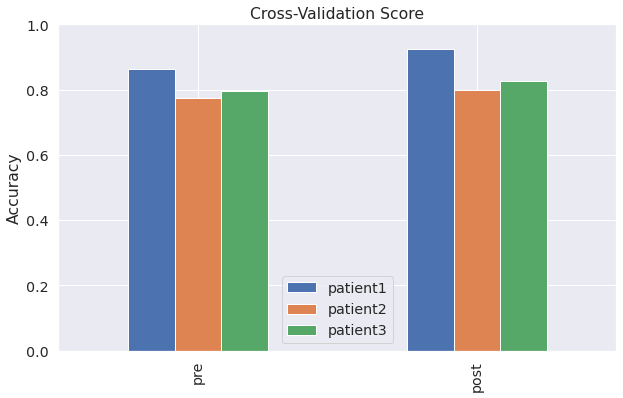

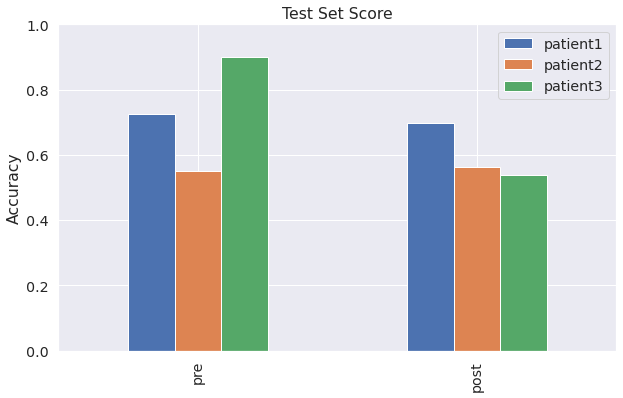

In [ ]:
df1=pd.DataFrame(cv_scores)
df2=pd.DataFrame(test_scores)

for patient in patients:
  for step in steps:
    print(patient,step,'  CrossVal Score: %0.3f' %cv_scores[patient][step],'  Test Score: %0.3f'%test_scores[patient][step])
print()
print('media sui cv score:  %0.3f'%df1.mean().mean(),' media sui test score: %0.3f'%df2.mean().mean())
df1.plot(kind='bar', figsize = (10,6),ylim=(0,1))
plt.ylabel("Accuracy")
plt.title("Cross-Validation Score")

df2.plot(kind='bar', figsize = (10,6),ylim=(0,1))
plt.ylabel("Accuracy")
plt.title("Test Set Score")

#2s Epoch Patient Specific
Questo BCI è stato creato per l'utilizzo online, quindi è necessaria un'implementazione più rapida, ora cerchiamo di implementare una versione più veloce del classificatore utilizzando epoche di prove più brevi.



In [ ]:
!unzip /content/drive/MyDrive/Risultati_2s.zip -d /content/Risultati_2s

Archive:  /content/drive/MyDrive/Risultati_2s.zip
   creating: /content/Risultati_2s/Risultati/
  inflating: /content/Risultati_2s/Risultati/Processed_P1_post_test.mat  
  inflating: /content/Risultati_2s/Risultati/Processed_P1_post_training.mat  
  inflating: /content/Risultati_2s/Risultati/Processed_P1_pre_test.mat  
  inflating: /content/Risultati_2s/Risultati/Processed_P1_pre_training.mat  
  inflating: /content/Risultati_2s/Risultati/Processed_P2_post_test.mat  
  inflating: /content/Risultati_2s/Risultati/Processed_P2_post_training.mat  
  inflating: /content/Risultati_2s/Risultati/Processed_P2_pre_test.mat  
  inflating: /content/Risultati_2s/Risultati/Processed_P2_pre_training.mat  
  inflating: /content/Risultati_2s/Risultati/Processed_P3_post_test.mat  
  inflating: /content/Risultati_2s/Risultati/Processed_P3_post_training.mat  
  inflating: /content/Risultati_2s/Risultati/Processed_P3_pre_test.mat  
  inflating: /content/Risultati_2s/Risultati/Processed_P3_pre_training.mat 

In [ ]:
path = "/content/Risultati_2s/Risultati" # Replace with your own folder path


data2s = {"patient1":{"pre":{},
                    "post": {}},
        "patient2":{"pre":{},
                    "post": {}},
        "patient3":{"pre":{},
                    "post": {}}
        }


# Patient 1
processed_P1_pre_training = io.loadmat(path + '/Processed_P1_pre_training.mat')
processed_P1_pre_test = io.loadmat(path + '/Processed_P1_pre_test')
processed_P1_post_training= io.loadmat(path + '/Processed_P1_post_training.mat')
processed_P1_post_test= io.loadmat(path + '/Processed_P1_post_test.mat')

# Patient 2
processed_P2_pre_training = io.loadmat(path + '/Processed_P2_pre_training.mat')
processed_P2_pre_test = io.loadmat(path + '/Processed_P2_pre_test')
processed_P2_post_training= io.loadmat(path + '/Processed_P2_post_training.mat')
processed_P2_post_test= io.loadmat(path + '/Processed_P2_post_test.mat')

# Patient 3
processed_P3_pre_training = io.loadmat(path + '/Processed_P3_pre_training.mat')
processed_P3_pre_test = io.loadmat(path + '/Processed_P3_pre_test')
processed_P3_post_training= io.loadmat(path + '/Processed_P3_post_training.mat')
processed_P3_post_test= io.loadmat(path + '/Processed_P3_post_test.mat')

keys = list(processed_P1_pre_training.keys())
for key in keys[:3]:
  processed_P1_pre_training.pop(key)
  processed_P1_pre_test.pop(key)
  processed_P1_post_training.pop(key)
  processed_P1_post_test.pop(key)

  processed_P2_pre_training.pop(key)
  processed_P2_pre_test.pop(key)
  processed_P2_post_training.pop(key)
  processed_P2_post_test.pop(key)

  processed_P3_pre_training.pop(key)
  processed_P3_pre_test.pop(key)
  processed_P3_post_training.pop(key)
  processed_P3_post_test.pop(key)



data2s["patient1"]["pre"]["train"]= processed_P1_pre_training
data2s["patient1"]["pre"]["test"]= processed_P1_pre_test
data2s["patient1"]["post"]["train"] = processed_P1_post_training
data2s["patient1"]["post"]["test"] = processed_P1_post_test

data2s["patient2"]["pre"]["train"]= processed_P2_pre_training
data2s["patient2"]["pre"]["test"]= processed_P2_pre_test
data2s["patient2"]["post"]["train"] = processed_P2_post_training
data2s["patient2"]["post"]["test"] = processed_P2_post_test

data2s["patient3"]["pre"]["train"]= processed_P3_pre_training
data2s["patient3"]["pre"]["test"]= processed_P3_pre_test
data2s["patient3"]["post"]["train"] = processed_P3_post_training
data2s["patient3"]["post"]["test"] = processed_P3_post_test

## Linear Disciminant Analysis

In [ ]:
#SCALER
scaler = Scaler(scalings='mean')
# CSP
csp = CSP(log=True,transform_into='average_power')

In [ ]:
clf = LinearDiscriminantAnalysis(shrinkage='auto')
# Parameters 
parameters_csp = {    'csp__n_components' : (4,6,8)}
parameters_clf = {
    'clf__solver' :('eigen','svd','lsqr')
}

## Logistic Regression

In [ ]:
clf = LogisticRegression(penalty='l2',n_jobs=-1)
# Parameters 
parameters_csp = {    'csp__n_components' : ((4,6,8))}
parameters_clf = {    'clf__C' :np.logspace(-1, 1, 5)   
}

## MultiLayer Perceptron

In [ ]:
clf = MLPClassifier(learning_rate='adaptive',max_iter=100,,activation='relu')
# Parameters 
parameters_csp = {    'csp__n_components' : ((8,))}

parameters_clf = {    'clf__hidden_layer_sizes':(100,500,1000),
                      'clf__alpha':(0.0001,0.001,0.01,0.1)
}

=======Performing grid search...========
pipeline: ['scaler', 'csp', 'clf']
parameters:
{'csp__n_components': (4, 6, 8), 'clf__solver': ('eigen', 'svd', 'lsqr')}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 16 dim * 4.2e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    5.5s finished


Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 16 dim * 5.1e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
done in 5.897s

Best CV score: 0.750
Best parameters set:
	clf__solver: 'eigen'
	csp__n_components: 8
Test score with best_estimator_: 0.812


=======Performing grid search...========
pipeline: ['scaler', 'csp', 'clf']
parameters:
{'csp__n_components': (4, 6, 8), 'clf__solver': ('eigen', 'svd', 'lsqr')}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    3.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.3s finished


Computing rank from data with rank=None
    Using tolerance 1.7 (2.2e-16 eps * 16 dim * 4.9e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 16 dim * 5e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
done in 3.617s

Best CV score: 0.860
Best parameters set:
	clf__solver: 'eigen'
	csp__n_components: 6
Test score with best_estimator_: 0.848


=======Performing grid search...========
pipeline: ['scaler', 'csp', 'clf']
parameters:
{'csp__n_components': (4, 6, 8), 'clf__solver': ('eigen', 'svd', 'lsqr')}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    3.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.3s finished


Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 16 dim * 5e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7 (2.2e-16 eps * 16 dim * 4.9e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
done in 3.602s

Best CV score: 0.688
Best parameters set:
	clf__solver: 'eigen'
	csp__n_components: 6
Test score with best_estimator_: 0.588


=======Performing grid search...========
pipeline: ['scaler', 'csp', 'clf']
parameters:
{'csp__n_components': (4, 6, 8), 'clf__solver': ('eigen', 'svd', 'lsqr')}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    3.0s remaining:    0.2s


Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 16 dim * 5e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.3s finished


Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 16 dim * 5.1e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
done in 3.577s

Best CV score: 0.700
Best parameters set:
	clf__solver: 'eigen'
	csp__n_components: 4
Test score with best_estimator_: 0.738


=======Performing grid search...========
pipeline: ['scaler', 'csp', 'clf']
parameters:
{'csp__n_components': (4, 6, 8), 'clf__solver': ('eigen', 'svd', 'lsqr')}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    3.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.2s finished


Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 16 dim * 5e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7 (2.2e-16 eps * 16 dim * 4.8e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
done in 3.475s

Best CV score: 0.808
Best parameters set:
	clf__solver: 'eigen'
	csp__n_components: 8
Test score with best_estimator_: 0.658


=======Performing grid search...========
pipeline: ['scaler', 'csp', 'clf']
parameters:
{'csp__n_components': (4, 6, 8), 'clf__solver': ('eigen', 'svd', 'lsqr')}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    3.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.2s finished


Computing rank from data with rank=None
    Using tolerance 1.7 (2.2e-16 eps * 16 dim * 4.9e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 16 dim * 5.2e+14  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
done in 3.561s

Best CV score: 0.738
Best parameters set:
	clf__solver: 'eigen'
	csp__n_components: 4
Test score with best_estimator_: 0.775




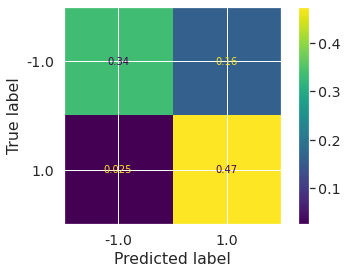

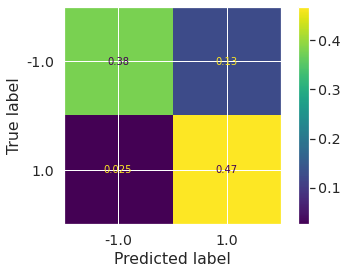

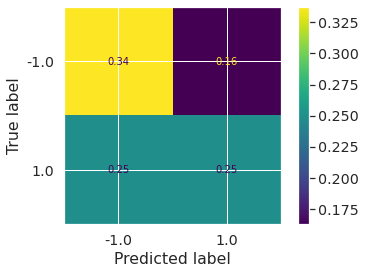

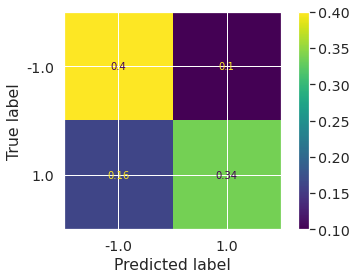

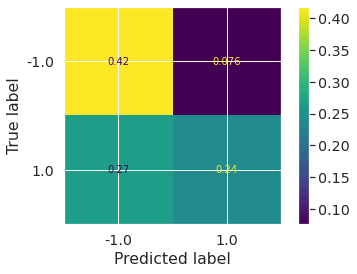

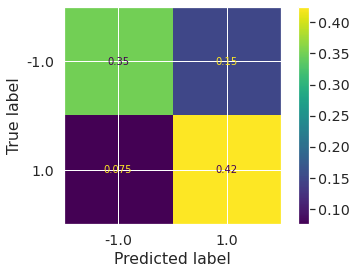

In [ ]:
test_scores = {"patient1":{"pre":{},"post": {}},"patient2":{"pre":{},"post": {}},"patient3":{"pre":{},"post": {}}}
cv_scores = {"patient1":{"pre":{},"post": {}},"patient2":{"pre":{},"post": {}},"patient3":{"pre":{},"post": {}}}
best_params = {"patient1":{"pre":{},"post": {}},"patient2":{"pre":{},"post": {}},"patient3":{"pre":{},"post": {}}}

patients = ['patient1', 'patient2', 'patient3']
steps=['pre','post']

for patient in patients:
  for step in steps:
      X_train=np.concatenate([data2s[patient][step]['train']['DxFilt'],
                                data2s[patient][step]['train']['SxFilt']])
      y_train=np.concatenate([-1*np.ones(len(data2s[patient][step]['train']['DxFilt'])),
                                np.ones(len(data2s[patient][step]['train']['SxFilt']))])
      grid_search= customized_GridSearch(clf, csp, parameters_clf, parameters_csp, X_train, y_train)
      cv_scores[patient][step]=grid_search.best_score_

      X_test=np.concatenate([data2s[patient][step]['test']['DxFilt'],data2s[patient][step]['test']['SxFilt']])
      y_test=np.concatenate([-1*np.ones(len(data2s[patient][step]['test']['DxFilt'])),
                            np.ones(len(data2s[patient][step]['test']['SxFilt']))])
      best_params[patient][step], test_scores[patient][step] = best_model_on_TestSet(grid_search, X_test, y_test)



patient1 pre   CrossVal Score: 0.750   Test Score: 0.812
patient1 post   CrossVal Score: 0.860   Test Score: 0.848
patient2 pre   CrossVal Score: 0.688   Test Score: 0.588
patient2 post   CrossVal Score: 0.700   Test Score: 0.738
patient3 pre   CrossVal Score: 0.808   Test Score: 0.658
patient3 post   CrossVal Score: 0.738   Test Score: 0.775

media sui cv score:  0.757  media sui test score: 0.736


Text(0.5, 1.0, 'Test Set Score')

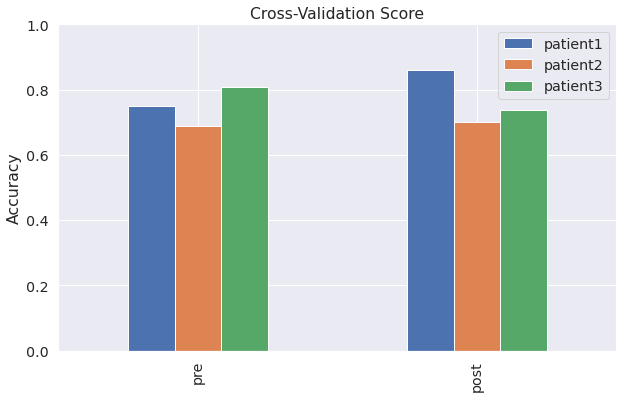

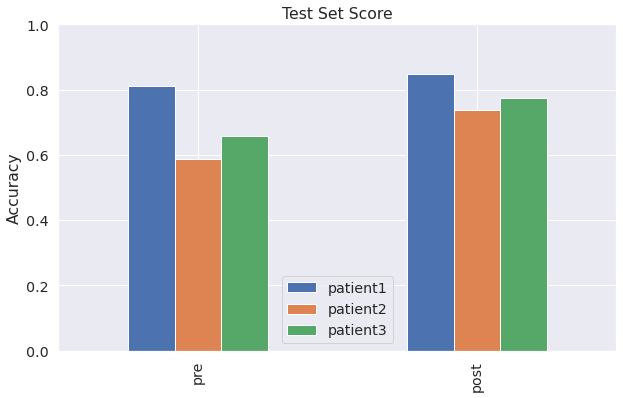

In [ ]:
df1=pd.DataFrame(cv_scores)
df2=pd.DataFrame(test_scores)

for patient in patients:
  for step in steps:
    print(patient,step,'  CrossVal Score: %0.3f' %cv_scores[patient][step],'  Test Score: %0.3f'%test_scores[patient][step])
print()
print('media sui cv score:  %0.3f'%df1.mean().mean(),' media sui test score: %0.3f'%df2.mean().mean())
df1.plot(kind='bar', figsize = (10,6),ylim=(0,1))
plt.ylabel("Accuracy")
plt.title("Cross-Validation Score")

df2.plot(kind='bar', figsize = (10,6),ylim=(0,1))
plt.ylabel("Accuracy")
plt.title("Test Set Score")

## Voting Classifier


In [ ]:
from sklearn.ensemble import VotingClassifier

clf = VotingClassifier(estimators=[('logreg',LogisticRegression(penalty='l2',n_jobs=-1)),
                                    ('mlp', MLPClassifier(learning_rate='adaptive',max_iter=100,,activation='relu')),
                                    ('lda',LinearDiscriminantAnalysis())],voting='soft')
cvscores=[]
testscores=[]

test_scores = {"patient1":{"pre":{},"post": {}}
               ,"patient2":{"pre":{},"post": {}}
               ,"patient3":{"pre":{},"post": {}}
              }
cv_scores = {"patient1":{"pre":{},"post": {}},
             "patient2":{"pre":{},"post": {}},
             "patient3":{"pre":{},"post": {}}
            }

for patient in patients:
  for step in steps:
    X_train=np.concatenate([data2s[patient][step]['train']['DxFilt'],
                            data2s[patient][step]['train']['SxFilt']])
    y_train=np.concatenate([-1*np.ones(len(data2s[patient][step]['train']['DxFilt'])),
                            np.ones(len(data2s[patient][step]['train']['SxFilt']))])
    
    X_test=np.concatenate([data2s[patient][step]['test']['DxFilt'],data2s[patient][step]['test']['SxFilt']])

    y_test=np.concatenate([-1*np.ones(len(data2s[patient][step]['test']['DxFilt'])),
                            np.ones(len(data2s[patient][step]['test']['SxFilt']))])
    
    csp=CSP(n_components=16,transform_into='average_power',cov_est='concat',component_order='alternate')
    X_train=csp.fit_transform(X_train,y_train)
    X_test=csp.fit_transform(X_test,y_test)

    clf.fit(X_train,y_train)
    score_gamma=cross_val_score(clf,X_train,y_train,cv=10,n_jobs=-1)
    cv_scores[patient][step]=np.mean(score_gamma)
    test_scores[patient][step]=clf.score(X_test,y_test)

Computing rank from data with rank=None
    Using tolerance 7.7 (2.2e-16 eps * 16 dim * 2.2e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 16 dim * 2.6e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.1 (2.2e-16 eps * 16 dim * 2.3e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.9 (2.2e-16 eps * 16 dim * 2.2e+15  max singular value)
    Estimated ra

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Computing rank from data with rank=None
    Using tolerance 9 (2.2e-16 eps * 16 dim * 2.5e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3 (2.2e-16 eps * 16 dim * 2.6e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 12 (2.2e-16 eps * 16 dim * 3.3e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 13 (2.2e-16 eps * 16 dim * 3.7e+15  max singular value)
    Estimated rank (

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


patient1 pre   CrossVal Score: 0.825   Test Score: 0.850
patient1 post   CrossVal Score: 0.875   Test Score: 0.797
patient2 pre   CrossVal Score: 0.825   Test Score: 0.725
patient2 post   CrossVal Score: 0.825   Test Score: 0.550
patient3 pre   CrossVal Score: 0.873   Test Score: 0.848
patient3 post   CrossVal Score: 0.787   Test Score: 0.787

media sui cv score:  0.835  media sui test score: 0.760


Text(0.5, 1.0, 'Test Set Score')

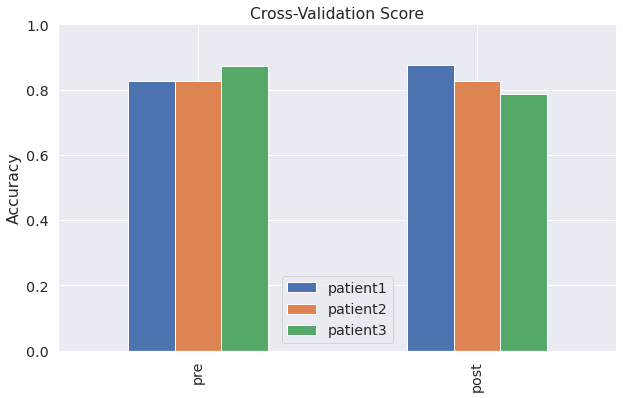

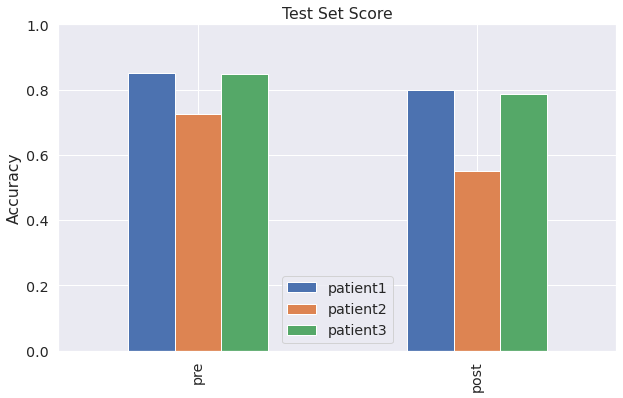

In [ ]:
df1=pd.DataFrame(cv_scores)
df2=pd.DataFrame(test_scores)

for patient in patients:
  for step in steps:
    print(patient,step,'  CrossVal Score: %0.3f' %cv_scores[patient][step],'  Test Score: %0.3f'%test_scores[patient][step])
print()
print('media sui cv score:  %0.3f'%df1.mean().mean(),' media sui test score: %0.3f'%df2.mean().mean())
df1.plot(kind='bar', figsize = (10,6),ylim=(0,1))
plt.ylabel("Accuracy")
plt.title("Cross-Validation Score")

df2.plot(kind='bar', figsize = (10,6),ylim=(0,1))
plt.ylabel("Accuracy")
plt.title("Test Set Score")

# Approach for a Generalized Model
L'idea é quella di creare un modello generalizzato:
Utilizziamo i dati di 2 pazienti per fare training e poi proviamo a classificare su un terzo paziente di cui il classificatore non ha mai visto i dati.


In [ ]:
def build_y(data, label):
    """Return required data labels"""
    return label * np.ones(len(data))

X_train = np.concatenate([data['patient1']['pre']['train']['DxFilt'], 
                          data['patient1']['pre']['train']['SxFilt'],
                          data['patient1']['post']['train']['DxFilt'], 
                          data['patient1']['post']['train']['SxFilt'],
                          data['patient2']['pre']['train']['DxFilt'], 
                          data['patient2']['pre']['train']['SxFilt'],
                          data['patient2']['post']['train']['DxFilt'], 
                          data['patient2']['post']['train']['SxFilt']])

y_train= np.concatenate([ build_y(data['patient1']['pre']['train']['DxFilt'], -1), 
                          build_y(data['patient1']['pre']['train']['SxFilt'] , 1),
                          build_y(data['patient1']['post']['train']['DxFilt'], -1), 
                          build_y(data['patient1']['post']['train']['SxFilt'] , 1),
                          build_y(data['patient2']['pre']['train']['DxFilt'], -1), 
                          build_y(data['patient2']['pre']['train']['SxFilt'], 1),
                          build_y(data['patient2']['post']['train']['DxFilt'], -1), 
                          build_y(data['patient2']['post']['train']['SxFilt'], 1),
                         ])
X_train.shape,y_train.shape

((319, 16, 2048), (319,))

In [ ]:
clf = MLPClassifier(max_iter=200)
# Parameters 
parameters_csp = {    'csp__n_components' : ((8,))}

parameters_clf = {    'clf__hidden_layer_sizes':(100,50,1000,),
                      'clf__alpha': np.logspace(-2, 1, 5),
}

In [ ]:
grid_search= customized_GridSearch(clf, csp, parameters_clf, parameters_csp, X_train, y_train)

=======Performing grid search...========
pipeline: ['scaler', 'csp', 'clf']
parameters:
{'csp__n_components': (8,), 'clf__hidden_layer_sizes': (100, 50, 1000), 'clf__alpha': array([ 0.01      ,  0.05623413,  0.31622777,  1.77827941, 10.        ])}
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.1min finished


Computing rank from data with rank=None
    Using tolerance 7 (2.2e-16 eps * 16 dim * 2e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7 (2.2e-16 eps * 16 dim * 2e+15  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
done in 125.731s

Best CV score: 0.702
Best parameters set:
	clf__alpha: 0.05623413251903491
	clf__hidden_layer_sizes: 100
	csp__n_components: 8


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


patient3 pre
Test score with best_estimator_: 0.582




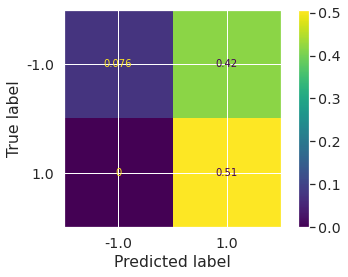

In [ ]:
patient='patient3'
step='pre'
testscores=[]
X_test=np.concatenate([data[patient][step]['test']['DxFilt'],
                        data[patient][step]['test']['SxFilt']])
y_test=np.concatenate([-1*np.ones(len(data[patient][step]['test']['DxFilt'])),
                      np.ones(len(data[patient][step]['test']['SxFilt']))])

print(patient,step)
best_params, scores = best_model_on_TestSet(grid_search, X_test, y_test)

# Conclusioni

- Non sono stati ottenuti risultati eccellenti in media, c´é **molta variabilitá** tra i pazienti.
- in media i migliori risultati li abbiamo ottenuti con il Voting Classifier combinando insieme Linear Discriminant Analysis, Logistic Regression e MultiLayer Perceptron


- Ho provato a implementare una **Neural Network Fully connected** in modo da aumentare la complessitá del modello e raggiungere un accuratezza sul training sample migliore ma senza risultati apprezzabili.


- I migliori risultati che abbiamo ottenuto sono quelli usando il **dataset piú completo** con le epoch da 8 secondi.


- Abbiamo comunque raggiunto dei risultati accettabili con il dataset con le epoch piú brevi da 2 secondi, sarebbe quindi possibili usare questo metodo per avere una classificazione e una risposta piú **rapida** durante il training.


- Mentre con il **metodo generalizzato** i risultati sono stati scarsi: una delle ragioni é nuovamente dovuta alla ampia variabilitá tra i pazienti e anche tra una sessione e l'altra.


- Un idea poteva essere quella di sfruttare tutti i 16 canali per aumentare i sample ma cosi avremmo perso le informazioni spaziali ricavate con il csp.




## Future Implementations
*  **Data Augmentation**: ci sono diversi modi di aumentare i dati a disposizione:
    * tramite un riscalamento, 
    * invertendo temporalmente il segnale, 
    * aggiugendo noise al segnale
    

*  Usare differenti metodi di Features Extraction: Il CSP probabilmente non ha estratto features cosí rilevanti al nostro scopo e scartandone altre che sarebbe state maggiormente rappresentative. Ci sono versioni piú elaborate e complesse di CSP 